In [50]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression

# シグモイド関数の定義（確率値の計算に使用）
def sigmoid(x):
    return 1./(1+np.exp(-x))

# シミュレーション用のクラス
class Simulator():
    # データ数を設定するメソッド
    def set_num_data(self, num_data):
        self.num_data = num_data

    # 線形モデルに従ったデータを生成するメソッド
    def generate_linear_data(self):
        num_data = self.num_data

        # x1, x2という説明変数を正規分布から生成し、それに基づいて確率・介入変数・報酬を生成
        self.df = pd.DataFrame({
            "x1": np.random.normal(size=num_data),
            "x2": np.random.normal(size=num_data),    
        }).assign(
            # 介入が行われる確率をシグモイド関数で計算
            prob_t = lambda df: sigmoid(df.x1**2+df.x2),
            # ランダムに介入の実施有無を決定（prob_tに基づく）
            t = lambda df: (df.prob_t >= np.random.uniform(size=num_data))*1,
            # 報酬はx1, x2に介入の有無を加味して決定
            reward = lambda df: df.x1 - df.x2 + df.t
        )
        return self.df

    # 非線形モデルに従ったデータを生成するメソッド
    def generate_nonlinear_data(self):
        num_data = self.num_data

        # x1, x2という説明変数を正規分布から生成し、それに基づいて確率・介入変数・報酬を生成
        self.df = pd.DataFrame({
            "x1": np.random.normal(size=num_data),
            "x2": np.random.normal(size=num_data),    
        }).assign(
            # 介入が行われる確率をシグモイド関数で計算（非線形な関係を反映）
            prob_t = lambda df: sigmoid(df.x1+df.x2),
            # ランダムに介入の実施有無を決定（prob_tに基づく）
            t = lambda df: (df.prob_t >= np.random.uniform(size=num_data))*1,
            # 報酬は非線形な関数で計算
            reward = lambda df: sigmoid(np.sin(df.x1) - df.x2**4) + df.t
        )
        return self.df

    # IPS（Inverse Probability Weighting）法による因果効果の推定
    def IPS(self):
        df = self.df
        # 介入の確率をロジスティック回帰で推定
        mode = LogisticRegression().fit(X=df[["x1", "x2"]], y=df["t"]==1)
        df["t_pred"] = mode.predict_proba(df[["x1", "x2"]])[:,1]

        # 介入が行われた場合と行われなかった場合の報酬を推定（逆確率重み付き平均）
        df["reward_treatment"] = df["reward"]*df["t"]/df["t_pred"]
        df["reward_no_treatment"] = df["reward"]*(1-df["t"])/(1-df["t_pred"])

        # 推定された因果効果の誤差（真の効果との差）を計算
        return abs((df["reward_treatment"]-df["reward_no_treatment"]).mean()-1)


    # CIPS (Clipped Inverse Propensity Score)
    def CIPS(self, lambda_=0.5):
        df = self.df
        # 介入の確率をロジスティック回帰で推定
        mode = LogisticRegression().fit(X=df[["x1", "x2"]], y=df["t"]==1)
        df["t_pred"] = mode.predict_proba(df[["x1", "x2"]])[:,1]

        df["weight_treatment"] = df["weight_treatment"] / df["weight_treatment"].sum()
        df["weight_no_treatment"] = df["weight_no_treatment"] / df["weight_no_treatment"].sum()

        df["weight_treatment"] = np.minimum(df["weight_treatment"], lambda_)
        df["weight_no_treatment"] = np.minimum(df["weight_no_treatment"], lambda_)

        # 介入が行われた場合と行われなかった場合の報酬を推定（逆確率重み付き平均）
        df["reward_treatment"] = df["reward"]*df["weight_treatment"]
        df["reward_no_treatment"] = df["reward"]*df["weight_no_treatment"]

        # 推定された因果効果の誤差（真の効果との差）を計算
        return abs((df["reward_treatment"]-df["reward_no_treatment"]).mean()-1)

    # SNIPS (Self-Normalized Inverse Propensity Score)
    def SNIPS(self):
        df = self.df
        # 介入の確率をロジスティック回帰で推定
        mode = LogisticRegression().fit(X=df[["x1", "x2"]], y=df["t"]==1)
        df["t_pred"] = mode.predict_proba(df[["x1", "x2"]])[:,1]
        
        df["weight_treatment"] = df["t"]/df["t_pred"]
        df["weight_no_treatment"] = (1-df["t"])/(1-df["t_pred"])

        df["weight_treatment"] = df["weight_treatment"] / df["weight_treatment"].sum()
        df["weight_no_treatment"] = df["weight_no_treatment"] / df["weight_no_treatment"].sum()
        # 介入が行われた場合と行われなかった場合の報酬を推定（逆確率重み付き平均）
        df["reward_treatment"] = df["reward"]*df["weight_treatment"]
        df["reward_no_treatment"] = df["reward"]*df["weight_no_treatment"]

        # 推定された因果効果の誤差（真の効果との差）を計算
        return abs((df["reward_treatment"]-df["reward_no_treatment"]).mean()-1)

    # DM（Direct Method）法による因果効果の推定
    def DM(self):
        df = self.df
        # 線形回帰で報酬を予測（説明変数はx1, x2, t）
        mode = LinearRegression().fit(X=df[["x1", "x2", "t"]], y=df["reward"])
        
        # 介入が行われた場合と行われなかった場合の報酬を予測
        df["reward_treatment"] = mode.predict(df[["x1", "x2", "t"]].assign(t=1))
        df["reward_no_treatment"] = mode.predict(df[["x1", "x2", "t"]].assign(t=0))

        # 推定された因果効果の誤差（真の効果との差）を計算
        return abs((df["reward_treatment"]-df["reward_no_treatment"]).mean()-1)

    def DR(self):
        df = self.df
        # 線形回帰で報酬を予測（説明変数はx1, x2, t）
        mode1 = LinearRegression().fit(X=df[["x1", "x2", "t"]], y=df["reward"])
        
        # 介入が行われた場合と行われなかった場合の報酬を予測
        df["reward_treatment_pred"] = mode1.predict(df[["x1", "x2", "t"]].assign(t=1))
        df["reward_no_treatment_pred"] = mode1.predict(df[["x1", "x2", "t"]].assign(t=0))

        # 介入の確率をロジスティック回帰で推定
        mode2 = LogisticRegression().fit(X=df[["x1", "x2"]], y=df["t"]==1)
        df["t_pred"] = mode2.predict_proba(df[["x1", "x2"]])[:,1]

        # 介入が行われた場合と行われなかった場合の報酬を推定（逆確率重み付き平均）
        df["weight_treatment"] = df["t"]/df["t_pred"]
        df["weight_no_treatment"] = (1-df["t"])/(1-df["t_pred"])

        df["reward_treatment"] = df["reward_treatment_pred"]+df["weight_treatment"]*(df["reward"]-df["reward_treatment_pred"])
        df["reward_no_treatment"] = df["reward_no_treatment_pred"]+df["weight_no_treatment"]*(df["reward"]-df["reward_no_treatment_pred"])

        # 推定された因果効果の誤差（真の効果との差）を計算
        return abs((df["reward_treatment"]-df["reward_no_treatment"]).mean()-1)

    # Switch-DR (Switch Doubly Robust)
    def SwitchDR(self, lambda_=0.5):
        df = self.df
        # 線形回帰で報酬を予測（説明変数はx1, x2, t）
        mode1 = LinearRegression().fit(X=df[["x1", "x2", "t"]], y=df["reward"])
        
        # 介入が行われた場合と行われなかった場合の報酬を予測
        df["reward_treatment_pred"] = mode1.predict(df[["x1", "x2", "t"]].assign(t=1))
        df["reward_no_treatment_pred"] = mode1.predict(df[["x1", "x2", "t"]].assign(t=0))

        # 介入の確率をロジスティック回帰で推定
        mode2 = LogisticRegression().fit(X=df[["x1", "x2"]], y=df["t"]==1)
        df["t_pred"] = mode2.predict_proba(df[["x1", "x2"]])[:,1]

        # 介入が行われた場合と行われなかった場合の報酬を推定（逆確率重み付き平均）
        df["weight_treatment"] = df["t"]/df["t_pred"]
        df["weight_no_treatment"] = (1-df["t"])/(1-df["t_pred"])

        df["weight_treatment"] = df["weight_treatment"] * (df["weight_treatment"] <= lambda_)
        df["weight_no_treatment"] = df["weight_no_treatment"] * (df["weight_no_treatment"] <= lambda_)

        df["reward_treatment"] = df["reward_treatment_pred"]+df["weight_treatment"]*(df["reward"]-df["reward_treatment_pred"])
        df["reward_no_treatment"] = df["reward_no_treatment_pred"]+df["weight_no_treatment"]*(df["reward"]-df["reward_no_treatment_pred"])

        # 推定された因果効果の誤差（真の効果との差）を計算
        return abs((df["reward_treatment"]-df["reward_no_treatment"]).mean()-1)

    # 線形データを使用したシミュレーション
    def sim_linear(self):
        ress = []
        # サンプルサイズを変えながらシミュレーションを実施
        for num_data in [100, 200, 400, 800, 1600, 6400, 12800]:
            res = {"num_data": num_data}
            self.set_num_data(num_data)
            ips = []
            dm = []
            dr = []
            cips = []
            snips = []
            switch_dr = []
            # 100回のシミュレーションを実行し、IPSとDMの推定精度を評価
            for _ in range(100):
                self.generate_linear_data()
                ips.append(self.IPS())
                dm.append(self.DM())
                dr.append(self.DR())
                cips.append(self.CIPS(lambda_=0.01))
                snips.append(self.SNIPS())
                switch_dr.append(self.SwitchDR(lambda_=0.01))
            # 各方法の平均推定誤差を記録
            res["IPS"] = np.mean(ips)
            res["DM"] = np.mean(dm)
            res["DR"] = np.mean(dr)
            res["CIPS"] = np.mean(cips)
            res["SNIPS"] = np.mean(snips)
            res["SDR"] = np.mean(switch_dr)
            ress.append(res)
        # サンプルサイズごとの結果をDataFrameで返す
        return pd.DataFrame(ress).set_index("num_data")

    # 非線形データを使用したシミュレーション
    def sim_nonlinear(self):
        ress = []
        # サンプルサイズを変えながらシミュレーションを実施
        for num_data in [100, 200, 400, 800, 1600, 12800]:
            res = {"num_data": num_data}
            self.set_num_data(num_data)
            ips = []
            dm = []
            dr = []
            cips = []
            snips = []
            switch_dr = []
            # 100回のシミュレーションを実行し、IPSとDMの推定精度を評価
            for _ in range(100):
                self.generate_nonlinear_data()
                ips.append(self.IPS())
                dm.append(self.DM())
                dr.append(self.DR())
                cips.append(self.CIPS(lambda_=0.01))
                snips.append(self.SNIPS())
                switch_dr.append(self.SwitchDR(lambda_=0.01))
            # 各方法の平均推定誤差を記録
            res["IPS"] = np.mean(ips)
            res["DM"] = np.mean(dm)
            res["DR"] = np.mean(dr)
            res["CIPS"] = np.mean(cips)
            res["SNIPS"] = np.mean(snips)
            res["SDR"] = np.mean(switch_dr)
            ress.append(res)
        # サンプルサイズごとの結果をDataFrameで返す
        return pd.DataFrame(ress).set_index("num_data")


In [51]:
simulator = Simulator()

,IPS,DM,DR,CIPS,SNIPS,SDR
num_data,,,,,,
100,0.132136,3.452794e-16,8.881784e-17,0.996929,0.991063,3.452794e-16
200,0.088126,2.686740e-16,5.218048e-17,0.997020,0.995230,2.686740e-16
400,0.052666,3.697043e-16,5.884182e-17,0.997985,0.997586,3.697043e-16
800,0.041059,2.942091e-16,4.440892e-18,0.998827,0.998774,2.942091e-16
1600,0.027098,5.817569e-16,6.661338e-18,0.999386,0.999382,5.817569e-16
6400,0.016002,5.284662e-16,0.000000e+00,0.999845,0.999845,5.284662e-16
12800,0.012994,7.582823e-16,0.000000e+00,0.999923,0.999923,7.582823e-16


<Axes: xlabel='num_data', ylabel='error'>

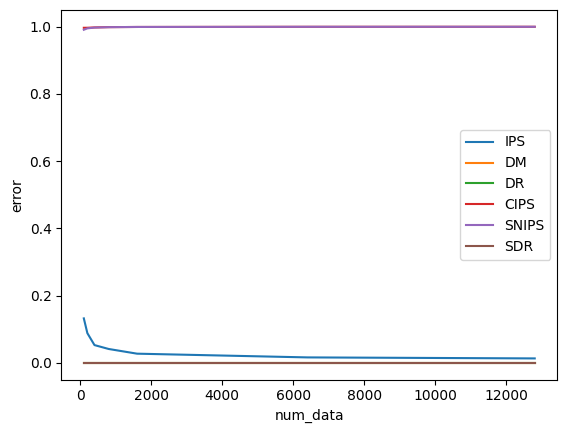

In [52]:
res = simulator.sim_linear()
display(res)
res.plot(ylabel="error")

c:\Users\sadan\OneDrive\Desktop\code\time_series_analysis\venv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


,IPS,DM,DR,CIPS,SNIPS,SDR
num_data,,,,,,
100,0.074792,0.038067,0.045149,0.994713,0.989827,0.038067
200,0.050793,0.029508,0.036053,0.995855,0.994971,0.029508
400,0.034527,0.020371,0.026837,0.997666,0.997506,0.020371
800,0.025333,0.015875,0.018131,0.998785,0.998750,0.015875
1600,0.022678,0.014224,0.011987,0.999380,0.999375,0.014224
12800,0.008215,0.013750,0.004554,0.999922,0.999922,0.013750


<Axes: xlabel='num_data', ylabel='error'>

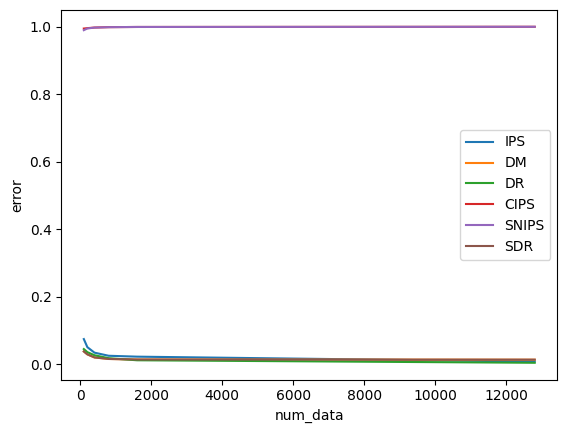

In [53]:
res = simulator.sim_nonlinear()
display(res)
res.plot(ylabel="error")